## Regional Analysis

### Steps

#### Step 1: Selection of regions of interest

In this step we try to rank regions by their contribution to CO2 amplitude variability over time.
We calculating each region's temporal CO2 amp variability and total area and rank them by the product of these measures.
We then select regions of interest by choosing those at the top of this ranking

1. Load regions data - DONE
2. Loop over regions. For each:
    - Calculate the variance in co2 flux seasonal amplitude - DONE
    - Calculate the total area
3. Rank the regions by amplitude*area - DONE
4. Select regions with highest variance (weighted by region area):
    - Calculate global sum of variance*area
    - Select regions from highest var*area down until a specific number ...


### Notes:

For regions, currently using the Koppen Geiger data from : http://koeppen-geiger.vu-wien.ac.at/


In [ ]:
import os
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import rasterio as rio
from matplotlib import pyplot
from rasterio.plot import show
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
# reading in regions and setting nodata values

# koga = rxr.open_rasterio('../data_input/KoeppenGeiger3_KG3_CRUTS32_Hist_7100.tif', mask_and_scale=False)
koga = rxr.open_rasterio(
    '../data_input/VU-VIENA/KG_1986-2010.grd', mask_and_scale=False)
koga.rio.write_nodata(32, inplace=True)
koga = koga.where(koga != koga.rio.nodata)
koga.rio.write_nodata(32, encoded=True, inplace=True)
koga = koga.rio.reproject("EPSG:4326")
print(koga.rio.crs)
# print(f"nodata: {koga.rio.nodata}")
# print(f"encoded_nodata: {koga.rio.encoded_nodata}")


In [ ]:

# Define required variables

cont_bounds = {'Asia': [24,-15,190,81], 'Europe': [-31, 35, 69, 81], 'North America': [-178, 0, -15, 84]}

koga_ind = np.unique(koga.data[~np.isnan(koga.data)]).astype(int)

# Color list and labels (including oceans as layer 32)
koga_cols = np.array(["#960000", "#FF0000", "#FF6E6E", "#FFCCCC", "#CC8D14", "#CCAA54", "#FFCC00", "#FFFF64", "#007800", "#005000",
          "#003200", "#96FF00", "#00D700", "#00AA00", "#BEBE00", "#8C8C00", "#5A5A00", "#550055", "#820082", "#C800C8",
          "#FF6EFF", "#646464", "#8C8C8C", "#BEBEBE", "#E6E6E6", "#6E28B4", "#B464FA", "#C89BFA", "#C8C8FF", "#6496FF",
          "#64FFFF", "#F5FFFF"])

koga_labels = np.array(['Af', 'Am', 'As', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb',
            'Cfc', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb', 'Cwc', 'Dfa', 'Dfb', 'Dfc',
            'Dfd', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd', 'EF',
            'ET', 'Ocean'])
            
# If setting ocean layer 32 as missing, do:
koga_cols = koga_cols[0:-1]
koga_labels = koga_labels[0:-1]


In [ ]:
# Plotting function: map plot of flux trends in the northern hemisphere

def plot_global(rast, cols, ticks, labels, fig_size):
    # cols is either a lost of colors or the name of an inbuilt matplotlib colormap
    
    if isinstance(cols, str):
        cmap = mpl.cm.get_cmap(cols)
    else:
        cmap = ListedColormap(cols)

    norm = mpl.colors.BoundaryNorm(np.append(ticks, ticks[-1]+1), ncolors=cmap.N)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(
        111,
        projection=ccrs.PlateCarree(),
        facecolor="white"
    )
    p = rast.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        # vmin=1., # activate vmin and vmax if not using norm
        # vmax=31., 
    )
    # ax.set_global()
    ax.coastlines()
    ax.set_title('Koeppen-Geiger Regions')
    cbar = fig.colorbar(p, label=None, ticks=ticks+np.append(np.diff(ticks)/2, 0.5)) # This sets the tick positions at the middle of the colorbar boxes
    cbar = cbar.ax.set_yticklabels(labels)


In [ ]:
# Plot regions to check all looks good.

plot_global(koga, koga_cols, koga_ind, koga_labels, [17,7])

## Regional analysis

In [ ]:
# read in files: co2 data and continent vector file
conts = gpd.read_file('../data_input/continents.geojson')
co2fluxamp = rxr.open_rasterio('../data_output/co2invSeasAmp_s99.nc')


# Create a template dataframe to save results
regind = np.unique(koga.data[~np.isnan(koga.data)]).astype(int)
df_regions = pd.DataFrame({'regind': regind, 'regname': koga_labels,
                          'regcolor': koga_cols, 'area': np.nan, 'co2amp_var': np.nan})
# Create a dictionary to hold dataframes for each continent
conts_dict = dict()

# Create area grid for co2fluxamp grid cells
latcos = np.cos(np.deg2rad(co2fluxamp.y))
latcos.name = "weights"
area_co2res = co2fluxamp[1].squeeze()
# Aproximate grid area at Equator
area_co2res = area_co2res.where(area_co2res.isnull(), other=(2 * 111) * (2.5 * 111))

# Reproject koga to co2 resolution
koga_rp = koga.rio.reproject_match(co2fluxamp)


In [ ]:
# Function to analyse for a chosen continent

def reg_analysis(cont_name):
    # cont_name is the continent name string as found in the conts geopandas object
    cont = conts[conts['CONTINENT'] == cont_name]
    koga_sel = koga_rp.rio.clip(cont.geometry, cont.crs, all_touched=True).rio.clip_box(
        minx=cont_bounds[cont_name][0],
        miny=cont_bounds[cont_name][1],
        maxx=cont_bounds[cont_name][2],
        maxy=cont_bounds[cont_name][3],
        crs="EPSG:4326"
    ).squeeze()  # Get rid of the 'band' dimension
    del koga_sel['band']
    
    # Make copy of DF to store results
    df_results = df_regions.copy()

    # Create list of region indices
    region_index = np.unique(koga_sel.data[~np.isnan(koga_sel.data)]).astype(int)

    # plot_global(koga_sel, koga_cols[(region_index-1)], koga_ind[(region_index-1)], koga_labels[(region_index-1)], [20,7])
    plot_global(koga_sel, koga_cols[(region_index-1)], region_index, koga_labels[(region_index-1)], [20,7])

    # Loop over region indices and calculate statistics of CO2 fluxes
    for i in range(len(region_index)):  # [15]: #
        roi = region_index[i]
        reg_co2amp = co2fluxamp.where(koga_sel == roi)
        reg_area = area_co2res.where(koga_sel == roi).weighted(latcos)
        totarea = reg_area.sum().data
        mean_var = reg_co2amp.var(dim='year').mean().data
        df_results.loc[df_results['regind'] ==
                       roi, 'ampvar'] = np.round(mean_var, 3)
        df_results.loc[df_results['regind'] == roi, 'area'] = np.round(totarea)

        # fig, ax = pyplot.subplots()
        # regfamp[1].plot(ax = ax)#, color = koga_cols[int(roi)-1])
        # conts.plot(ax = ax, facecolor="none", edgecolor="black")

    df_results = df_results.loc[~df_results['area'].isna(),:]
    df_results['area_ampvar'] = np.round(
        df_results['area'] * df_results['ampvar'])
    df_results = df_results.sort_values('area_ampvar', ascending=False)
    df_results['area_ampvar_sum_cont'] = df_results['area_ampvar'].cumsum()
    amparea_sum = df_results['area_ampvar'].sum()

    print('Total amparea sum = : ', amparea_sum, '\n')
    print('80% of amparea sum = : ', amparea_sum * 0.8, '\n')

    # Explore data
    df_results.sort_values('area', ascending=False).plot.bar('regname', 'area')
    df_results.sort_values('ampvar', ascending=False).plot.bar(
        'regname', 'ampvar')
    df_results.sort_values('area_ampvar', ascending=False).plot.bar(
        'regname', 'area_ampvar')
    
    df_results['continent'] = cont_name

    return (df_results)


### Analysis for each NH continent

In [ ]:
df_co2_as = reg_analysis("Asia")

In [ ]:
df_co2_eu = reg_analysis("Europe")

In [ ]:
df_co2_na = reg_analysis("North America")

In [ ]:
# Concatenate data frames
df_co2_glob = pd.concat([df_co2_as, df_co2_eu, df_co2_na], axis=0)
df_co2_glob = df_co2_glob.sort_values('area_ampvar', ascending=False)
df_co2_glob['area_ampvar_sum_glob'] = df_co2_glob['area_ampvar'].cumsum()

In [ ]:
# Calculating total area
amparea_sum = df_co2_glob['area_ampvar'].sum()
print('Total amparea sum = : ', amparea_sum, '\n')
print('80% of amparea sum = : ', amparea_sum * 0.8, '\n')

In [88]:
# Replace values with area*amp and plot

def recodeConts():
    conts_out = dict()
    cont_names = ['Asia', 'Europe', 'North America']

    for cont_name in cont_names:
        cont = conts[conts['CONTINENT'] == cont_name]
        koga_sel = koga_rp.rio.clip(cont.geometry, cont.crs, all_touched=True).rio.clip_box(
            minx=cont_bounds[cont_name][0],
            miny=cont_bounds[cont_name][1],
            maxx=cont_bounds[cont_name][2],
            maxy=cont_bounds[cont_name][3],
            crs="EPSG:4326"
        ).squeeze()  # Get rid of the 'band' dimension
        del koga_sel['band']

        # Create list of region indices
        region_index = np.unique(koga_sel.data[~np.isnan(koga_sel.data)]).astype(int)

        for i in range(len(region_index)):
            regind = region_index[i]
            areaampvar = df_co2_glob.loc[(df_co2_glob['continent'] == cont_name) & (df_co2_glob['regind'] == regind), 'area_ampvar'].to_numpy()
            koga_sel= xr.where(koga_sel == regind, areaampvar, koga_sel)
        
        conts_out[cont_name] = koga_sel
    
    koga_aa = conts_out['Asia'].combine_first(conts_out['Europe']).combine_first(conts_out['North America'])
    return(koga_aa)

koga_aa = recodeConts()



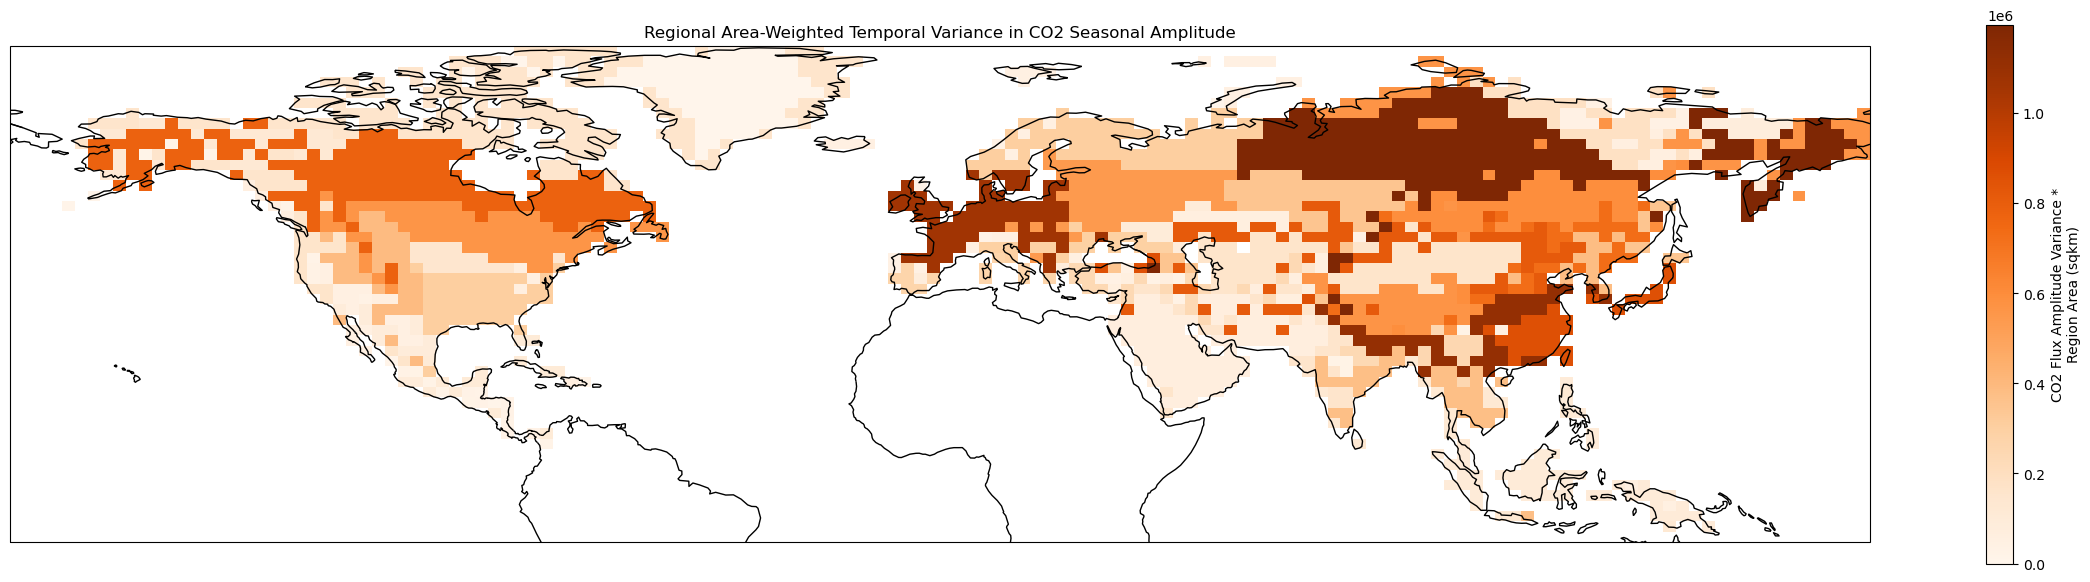

In [90]:
# Make a plot of Area Weighted ----
def plotGradMap(rast, cols):
    cmap = mpl.cm.get_cmap(cols)
    fig = plt.figure(figsize=[30,7])
    ax = fig.add_subplot(
        111,
        projection=ccrs.PlateCarree(),
        facecolor="white"
    )
    p = rast.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        # add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title('Regional Area-Weighted Temporal Variance in CO2 Seasonal Amplitude')

koga_aa.attrs['long_name'] = 'CO2 Flux Amplitude Variance * Region Area (sqkm)'
plotGradMap(koga_aa, 'Oranges')

